In [1]:
import sys
sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *

from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *
from mrl.reward import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)

In [3]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = TextDataset(['CCC'], vocab)

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))

loss = CrossEntropy()

In [4]:
# vh = ValueHead(400)
vh = ValueHead(256)
# vh = None

In [5]:
# latents = torch.randn((1024, lm_model.encoder.d_latent))
latents = None

In [6]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, value_head=vh, opt_kwargs={'lr':1e-4},
                       base_update=0.97, v_update=0.9, vopt_kwargs={'lr':1e-3},
                       latents=latents, lopt_kwargs={'lr':5e-2})

In [7]:
# reference = 'O=C(CCCCCCn1cc(-c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nn1)NO'
# scaffold = '*c1ccc2ncnc(Nc3cccc(Cl)c3F)c2c1'

# reference = 'Cn1cc(-c2ccc3ncnc(Nc4cccc(Cl)c4F)c3c2)nn1'
# scaffold = '*c1ncnc2ccc(-c3cn(C)nn3)cc12'

reference = 'Cn1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c3c2)nn1'
scaffold = '*c1ccc2ncnc(Cc3cccc(C(C(=O)O)C(O)F)c3)c2c1'

In [8]:
r_template = Template(
                    [MolWtFilter(20, 200),
                     RingFilter(1,2)],
                    [],
                    fail_score=-1, log=True
                    )

smarts = ['[#6](=[#16])(-[#7])-[#7]',
        '[H]-[#6](-[H])=[#6]-[*]',
        '[#6]=[#6]=[#6]',
        '[#7][F,Cl,Br,I]',
        '[#6;!R]=[#6;!R]-[#6;!R]=[#6;!R]']



full_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     RotBondFilter(None, 8),
                     HeteroatomFilter(None, 10),
                     ChargeFilter(None, 0),
                     MaxRingFilter(None, 6),
                     MinRingFilter(5, None),
                     HBDFilter(None, 5),
                     HBAFilter(None, 10),
                     MolWtFilter(None, 500),
                     LogPFilter(None, 5),
                     SAFilter(None, 7),
                     BridgeheadFilter(None,0),
                     PAINSAFilter(),
                     ExclusionFilter(smarts, criteria='any'),
                     RotChainFilter(None, 7)
                    ],
                    [], 
                    fail_score=-10., log=True, use_lookup=True)

template = RGroupBlockTemplate(scaffold, r_template, 
                                    full_molecule_template=full_template)

In [9]:
df = pd.read_csv('../../smiles_datasets/single_frags.csv')

In [10]:
df.head()

,smiles,attachments,weight,atoms
0,*CCOc1c(O)cc(CNC)cc1F,1,198.093032,14
1,*C(C)Oc1c(O)cc(CNC)cc1F,1,198.093032,14
2,*N(C)Cc1cc(O)c(OCC)c(F)c1,1,198.093032,14
3,*Oc1cc(CNC)cc(F)c1OCC,1,198.093032,14
4,*Oc1cc(O)ncc1C(=O)NCCO,1,197.056232,14


In [11]:
df = df[df.weight<175]

In [12]:
df.shape

(1595133, 4)

In [13]:
os.environ['ncpus'] = '64'

In [14]:
screened = template.recurse_fragments(df.smiles.values)

In [15]:
os.environ['ncpus'] = '0'

In [16]:
screened = [i for i in screened if i[2]]

In [17]:
screened = [i[0] for i in screened]
screened = [i.replace('[2*:1]', '*') for i in screened]

In [18]:
screened = list(set(screened))

In [19]:
len(screened)

315334

In [20]:
agent.update_dataset_from_inputs(screened)

In [22]:
df = pd.DataFrame(screened, columns=['smiles'])
df.to_csv('rgroup_screened.csv', index=False)

In [9]:
df = pd.read_csv('rgroup_screened.csv')

In [10]:
os.environ['ncpus'] = '64'
_ = template.recurse_fragments(df.smiles.values)
os.environ['ncpus'] = '0'

In [11]:
agent.update_dataset_from_inputs(df.smiles.values)
agent.train_supervised(256, 3, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.54983,0.47618,00:42
1,0.49669,0.46393,00:42
2,0.50096,0.46093,00:42


<All keys matched successfully>

In [12]:
update_cb = UpdateBaselineCB(agent, 5, 'base_update')
stat_cb = StatsCallback('live', 'stat_cb', 10)
roll_cb = RetrainRollback(agent, 98, 0.5, 5e-5, 64, 'live_valid', 100, 0.2, 'rb')
reward_cb = LogSampler('rewards', 10, 95, buffer_size=15)
enum_cb = LogEnumerator('rewards', 10, buffer_size=3, percentile=98)
train_cb = SupevisedCB(agent, 200, 0.5, 98, 5e-5, 64)
novel_cb = NoveltyBonus(0.1, 'novel')

In [13]:
cbs = [update_cb, stat_cb, roll_cb, reward_cb, enum_cb, novel_cb, train_cb]

In [14]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')

r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/aff_pred.pt')

r_model.eval();

freeze(r_model)

aff_reward = SampleReward(r_agent.predict_data, True, 'aff', weight=-10.)

In [15]:
gen_bs = 2000
bs = 200

In [16]:
agent_cb = GenAgentCallback(agent, 'generative')

In [17]:
sampler1 = ModelSampler(agent, agent.model, 'live', 2000, 0.4, gen_bs, latent=False)
sampler2 = ModelSampler(agent, agent.base_model, 'base', 2000, 0., gen_bs)

samplers = [sampler1, sampler2]

In [18]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss1 = LossCallback(pg, 'pg')

In [19]:
template_cb = TemplateCallback(template, prefilter=True)

In [20]:
env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss1],
                 cbs=cbs)

In [18]:
%%time
env.fit(bs, 90, 6, 2)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
0,-3.720,0.000,1.000,0.690,129,0.616,1.000,0.275,-3.811,1.000,-3.820,-2.124,-1.500,0.100
2,-3.854,0.000,1.000,0.676,123,0.580,1.000,0.263,-3.843,1.000,-3.954,-2.330,-1.301,0.100
4,-3.891,0.000,1.000,0.672,131,0.596,1.000,0.200,-3.552,1.000,-3.991,-1.694,-1.323,0.100


CPU times: user 2min 29s, sys: 2.7 s, total: 2min 31s
Wall time: 11.7 s


In [21]:
env.sl = 45
env.bs = 10000
env.build_buffer()

In [22]:
len(env.buffer.buffer), len(set(env.buffer.buffer))

(3228, 3228)

In [23]:
%%time
env.fit(bs, 45, 50, 5)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
0,-0.299,0.000,1.000,0.925,185,0.227,1.000,0.812,-0.205,1.000,-0.399,0.873,1.567,0.100
5,-0.326,0.000,1.000,0.915,183,0.308,1.000,0.787,-0.290,1.000,-0.426,0.856,2.025,0.100
10,-0.186,0.000,1.000,0.950,190,0.272,1.000,0.875,0.080,0.986,-0.286,1.231,2.193,0.099
15,-0.045,0.000,1.000,0.920,184,0.232,1.000,0.800,0.169,1.000,-0.145,1.218,1.827,0.100
20,-0.216,0.000,1.000,0.935,187,0.154,1.000,0.838,0.027,0.970,-0.315,1.102,1.870,0.099
25,-0.315,0.000,1.000,0.940,188,0.215,1.000,0.850,-0.054,1.000,-0.413,1.097,1.603,0.099
30,-0.039,0.000,1.000,0.920,184,0.141,1.000,0.800,0.039,0.984,-0.138,1.091,1.809,0.099
35,-0.049,0.000,1.000,0.900,180,0.208,1.000,0.750,0.093,0.967,-0.146,1.202,2.067,0.098
40,-0.098,0.000,0.995,0.930,186,0.219,1.000,0.825,-0.023,0.955,-0.195,1.213,1.888,0.097
45,-0.167,0.000,1.000,0.905,181,0.205,1.000,0.762,-0.015,0.984,-0.263,0.933,1.685,0.097


CPU times: user 11min 25s, sys: 14.5 s, total: 11min 39s
Wall time: 51.6 s


In [24]:
env.log.timelog['sample_batch']

[0.5437886714935303,
 0.52874755859375,
 0.5149474143981934,
 0.48062992095947266,
 0.5340955257415771,
 0.5263662338256836,
 0.5452876091003418,
 0.527768611907959,
 0.5486016273498535,
 0.5253820419311523,
 0.5062079429626465,
 0.5386688709259033,
 0.5060610771179199,
 0.5143568515777588,
 0.5171809196472168,
 0.5075206756591797,
 0.5142371654510498,
 0.5067441463470459,
 0.5323677062988281,
 0.5158610343933105,
 0.4891397953033447,
 0.5243065357208252,
 0.5498809814453125,
 0.532095193862915,
 0.4904768466949463,
 0.5038108825683594,
 0.5460371971130371,
 0.5304718017578125,
 0.5297439098358154,
 0.5343971252441406,
 0.5157468318939209,
 0.5196151733398438,
 0.5416021347045898,
 0.5449347496032715,
 0.4831721782684326,
 0.563751220703125,
 0.5516331195831299,
 0.5142836570739746,
 0.5457758903503418,
 0.5319690704345703,
 0.5371167659759521,
 0.5586278438568115,
 0.5406439304351807,
 0.4934999942779541,
 0.524451494216919,
 0.5668766498565674,
 0.5471234321594238,
 0.533954381942749

In [36]:
%%time
env.fit(bs, 45, 1000, 5)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
0,-0.423,0.000,1.000,0.930,186,0.347,1.000,0.825,-0.519,1.000,-0.523,0.566,2.117,0.100
5,-0.333,0.000,1.000,0.940,188,0.269,1.000,0.850,-0.309,1.000,-0.433,0.651,1.754,0.099
10,-0.303,0.000,1.000,0.945,189,0.286,1.000,0.863,-0.492,1.000,-0.403,0.675,1.140,0.100
15,-0.370,0.000,1.000,0.910,182,0.277,1.000,0.775,-0.207,0.984,-0.470,1.096,2.120,0.099
20,-0.313,0.000,1.000,0.940,188,0.240,1.000,0.850,-0.184,1.000,-0.413,0.820,1.524,0.100
25,-0.244,0.000,1.000,0.915,183,0.216,1.000,0.787,-0.263,1.000,-0.343,1.015,1.527,0.099
30,-0.146,0.000,1.000,0.920,184,0.174,1.000,0.800,-0.087,0.969,-0.245,0.813,1.809,0.099
35,-0.146,0.000,1.000,0.905,181,0.195,1.000,0.762,-0.029,1.000,-0.245,1.050,1.386,0.099
40,-0.252,0.000,1.000,0.950,190,0.185,1.000,0.875,-0.206,0.971,-0.350,0.963,1.609,0.097
45,-0.212,0.000,1.000,0.940,188,0.185,1.000,0.850,0.003,0.956,-0.309,1.143,1.900,0.097


Epoch,Train Loss,Valid Loss,Time
0,0.48178,0.44113,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.42447,0.41515,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.45210,0.52203,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.47464,0.49815,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46817,0.55679,00:00


CPU times: user 3h 43min 6s, sys: 8min 10s, total: 3h 51min 17s
Wall time: 33min 20s


In [39]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])
log_df.drop_duplicates(subset='samples', inplace=True)

In [44]:
log_df[(log_df.rewards>1) & (log_df.template>-5)].shape

(16863, 7)

In [43]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))
agent.update_dataset_from_inputs(screened)
agent.train_supervised(256, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.51382,0.47644,00:42


<All keys matched successfully>

In [45]:
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>0) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.47958,0.49582,00:11


<All keys matched successfully>

In [46]:
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>1) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.49354,0.51519,00:03


<All keys matched successfully>

In [28]:
%%time
env.fit(bs, 45, 500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
500,-3.221,0.000,1.000,0.900,180,1.104,1.000,0.750,-4.178,0.867,-3.289,-1.489,-0.224,0.068
510,-4.306,0.000,1.000,0.910,182,1.094,1.000,0.775,-4.424,0.855,-4.395,-2.153,-0.273,0.089
520,-4.040,0.000,1.000,0.875,175,1.014,1.000,0.688,-4.115,0.782,-4.124,-1.920,-1.105,0.083
530,-4.199,0.000,1.000,0.880,176,0.929,1.000,0.700,-3.626,0.768,-4.281,-1.019,0.250,0.082
540,-4.021,0.000,1.000,0.900,180,0.882,1.000,0.750,-4.093,0.783,-4.108,-1.629,-0.185,0.088
550,-3.935,0.000,1.000,0.910,182,0.816,1.000,0.775,-3.866,0.806,-4.020,-1.403,0.242,0.085
560,-3.859,0.000,0.995,0.915,183,0.667,0.984,0.787,-3.661,0.714,-3.935,-1.318,-0.315,0.075
570,-4.195,0.000,1.000,0.895,179,0.788,1.000,0.738,-3.944,0.797,-4.275,-1.678,0.161,0.080
580,-4.332,0.000,1.000,0.910,182,0.779,1.000,0.775,-4.144,0.806,-4.411,-1.920,-0.751,0.079
590,-3.984,0.000,1.000,0.925,185,0.771,1.000,0.812,-3.748,0.846,-4.069,-1.160,0.027,0.085


Epoch,Train Loss,Valid Loss,Time
0,0.46408,0.51385,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.55356,0.47048,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46640,0.45271,00:00


CPU times: user 1h 48min 42s, sys: 1min 47s, total: 1h 50min 29s
Wall time: 9min 30s


In [29]:
log_df = log_to_df(env.log.log, ['samples', 'sources', 'rewards', 'template', 'aff', 'novel'])
log_df.drop_duplicates(subset='samples', inplace=True)

In [34]:
log_df[(log_df.rewards>-1) & (log_df.template>-5)].shape

(5862, 7)

In [33]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_rgroup.pt'))
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>-2.5) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.48001,0.52436,00:05


<All keys matched successfully>

In [35]:
agent.update_dataset_from_inputs(
    log_df[(log_df.rewards>-1) & (log_df.template>-5)].samples.values)
agent.train_supervised(64, 1, 5e-5)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.53206,0.49855,00:01


<All keys matched successfully>

In [49]:
%%time
env.fit(bs, 45, 500, 10)

iterations,rewards,template,diversity,valid,bs,pg,live_diversity,live_valid,live_rewards,live_new,aff,live_p90,live_max,novel
1000,1.167,0.000,1.000,0.865,173,0.103,1.000,0.662,0.765,0.434,1.141,1.621,2.033,0.026
1010,0.620,0.000,1.000,0.870,174,0.174,1.000,0.675,0.639,0.278,0.574,1.584,2.177,0.046
1020,0.572,0.000,1.000,0.920,184,0.171,1.000,0.800,0.561,0.234,0.533,1.665,2.314,0.040
1030,0.632,0.000,1.000,0.935,187,0.145,1.000,0.838,0.639,0.313,0.594,1.472,2.033,0.039
1040,0.640,0.000,1.000,0.920,184,0.143,1.000,0.800,0.632,0.312,0.600,1.609,2.227,0.040
1050,0.730,0.000,1.000,0.920,184,0.189,1.000,0.800,0.683,0.344,0.692,1.594,2.153,0.039
1060,0.750,0.000,0.995,0.915,183,0.166,1.000,0.787,0.715,0.175,0.713,1.743,2.425,0.037
1070,0.589,0.000,1.000,0.895,179,0.146,1.000,0.738,0.578,0.322,0.541,1.578,2.147,0.047
1080,0.712,0.000,0.995,0.925,185,0.112,0.985,0.812,0.766,0.292,0.672,1.724,2.147,0.040
1090,0.832,0.000,0.995,0.915,183,0.104,1.000,0.787,0.945,0.190,0.798,1.882,2.144,0.034


Epoch,Train Loss,Valid Loss,Time
0,0.46028,0.43162,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.55246,0.44194,00:00


CPU times: user 1h 41min 42s, sys: 4min 6s, total: 1h 45min 49s
Wall time: 15min 46s


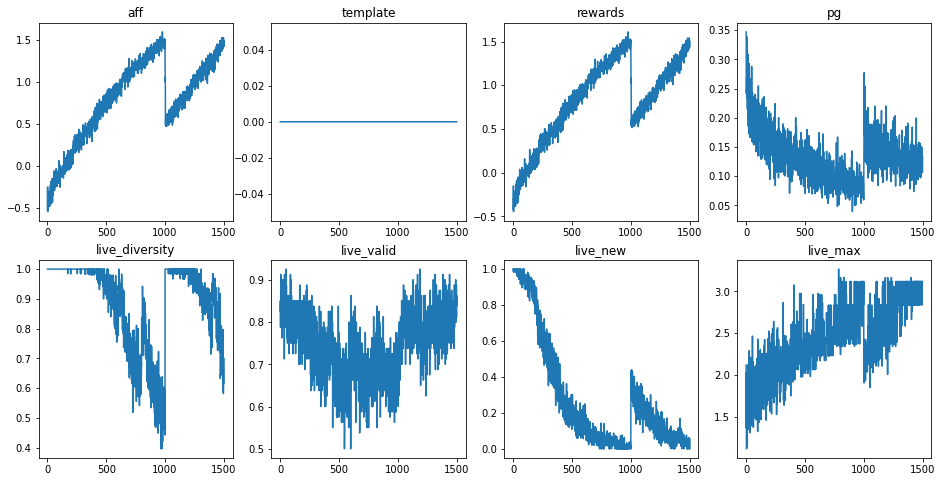

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['aff', 'template', 'rewards', 'pg',
             'live_diversity', 'live_valid', 'live_new', 'live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

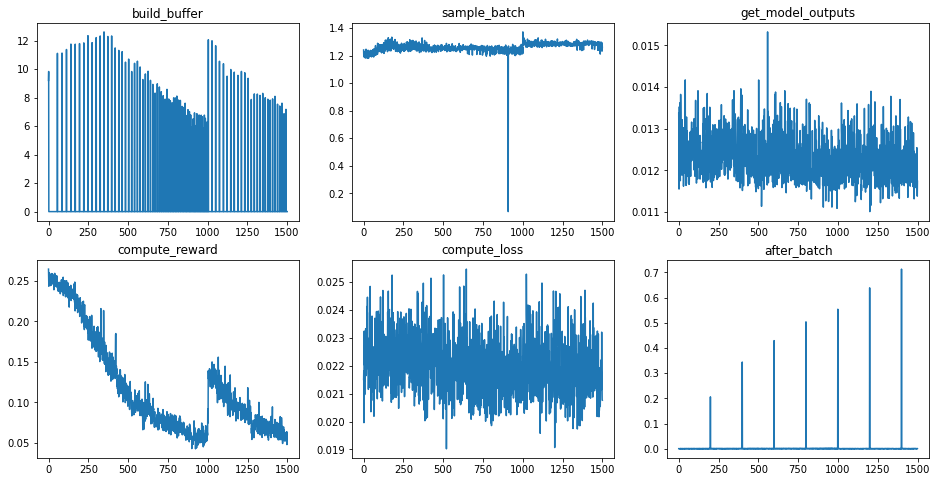

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

In [52]:
-10*r_agent.predict_data([reference])

tensor([[2.8321]], device='cuda:1')

In [53]:
log_df = log_to_df(env.log.log, ['samples', 'samples_fused', 'sources', 'rewards', 'template', 'aff', 'novel'])

In [54]:
log_df.drop_duplicates(subset='samples', inplace=True)

In [55]:
log_df[log_df.aff>-10*r_agent.predict_data([reference]).item()]

,batch,samples,samples_fused,sources,rewards,template,aff,novel
74056,406,*c1cn(-c2ccncc2)nn1,O=C(O)C(c1cccc(Cc2ncnc3ccc(-c4cn(-c5ccncc5)nn4...,live,3.076818,0.0,2.976818,0.1
75770,416,*c1cc(C(N)=O)c(SC)s1,CSc1sc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c...,buffer,3.062586,0.0,2.962586,0.1
80499,442,*c1cn(C)nn1,Cn1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c3...,buffer,2.932096,0.0,2.832096,0.1
98421,545,*c1cc(C(N)=S)c(O)s1,NC(=S)c1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)...,buffer,2.936619,0.0,2.836619,0.1
110964,617,*c1cc(C(C)=NO)c(O)s1,CC(=NO)c1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F...,buffer,3.219510,0.0,3.119510,0.1
111912,622,*c1cc(C(C)=NN)c(O)s1,CC(=NN)c1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F...,live,2.938293,0.0,2.838293,0.1
118288,658,*c1cn(N)nn1,Nn1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c3...,buffer,3.014809,0.0,2.914809,0.1
140458,786,*c1cc(S)c(F)c(SC)n1,CSc1nc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c...,live,3.267607,0.0,3.167607,0.1
142790,800,*c1cn(C(=O)c2ccncc2)cn1,O=C(O)C(c1cccc(Cc2ncnc3ccc(-c4cn(C(=O)c5ccncc5...,buffer,3.002851,0.0,2.902852,0.1
146007,818,*c1c(C(=O)O)ccc(O)c1CO,O=C(O)c1ccc(O)c(CO)c1-c1ccc2ncnc(Cc3cccc(C(C(=...,buffer,3.004700,0.0,2.904700,0.1


In [56]:
log_df[log_df.aff>3]

,batch,samples,samples_fused,sources,rewards,template,aff,novel
110964,617,*c1cc(C(C)=NO)c(O)s1,CC(=NO)c1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F...,buffer,3.219510,0.0,3.119510,0.1
140458,786,*c1cc(S)c(F)c(SC)n1,CSc1nc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)c...,live,3.267607,0.0,3.167607,0.1
157280,882,*c1cn(C(C)=CCO)nn1,CC(=CCO)n1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)...,buffer,3.160275,0.0,3.060275,0.1
157496,883,*c1cn(C=CC(C)(C)N)nn1,CC(C)(N)C=Cn1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C...,buffer,3.146874,0.0,3.046874,0.1
229729,1284,*c1cc(C(C)=NS)c(O)s1,CC(=NS)c1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F...,buffer,3.163531,0.0,3.063531,0.1
231259,1292,*c1cn(C=N)nn1,N=Cn1cc(-c2ccc3ncnc(Cc4cccc(C(C(=O)O)C(O)F)c4)...,buffer,3.193846,0.0,3.093846,0.1


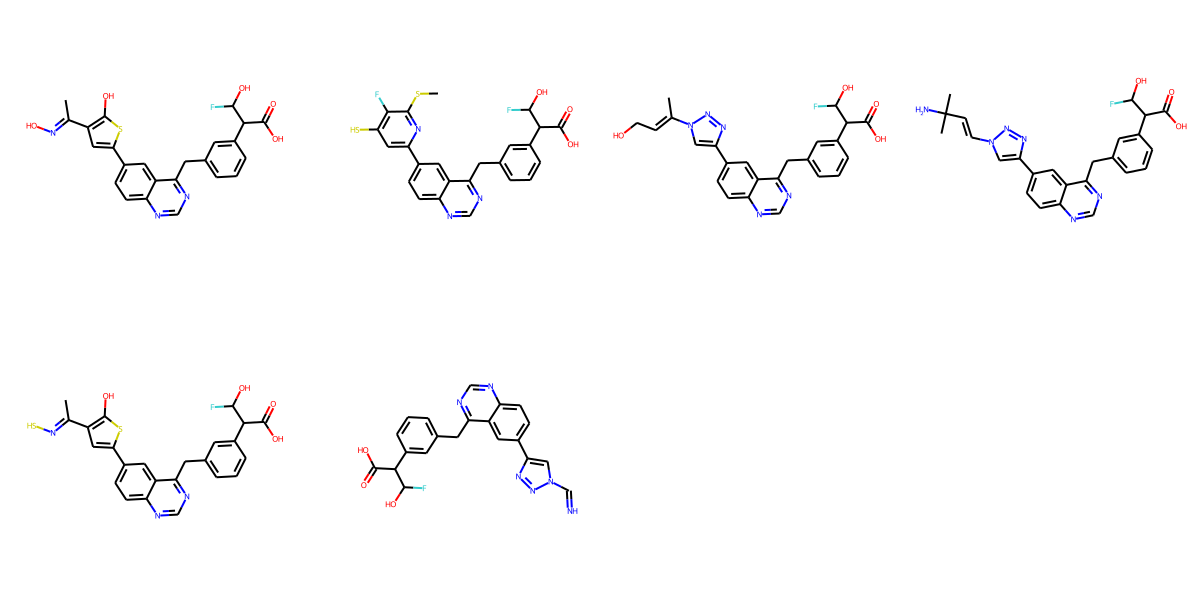

In [57]:
draw_mols(to_mols(log_df[log_df.aff>3].samples_fused.values), mols_per_row=4)

In [58]:
%%time
_ = samplers[0]._sample_batch()

CPU times: user 905 ms, sys: 33.1 ms, total: 938 ms
Wall time: 55.4 ms


In [59]:
%%time
_ = samplers[1]._sample_batch()

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 10 µs


In [60]:
%%time
env.sample_batch()

CPU times: user 7.03 s, sys: 492 ms, total: 7.52 s
Wall time: 1.31 s


In [72]:
t1 = time.time()
env.batch_state = BatchState()
for cb in env.cbs:
    cb.batch_state = env.batch_state
t2 = time.time()
env('before_batch') 
t3 = time.time()
env('sample_batch') 
t4 = time.time()

# env('after_sample') 
# t5 = time.time()

In [73]:
%%time
valids = template_cb.filter_sequences(env.batch_state.samples, return_array=True)

CPU times: user 931 ms, sys: 212 ms, total: 1.14 s
Wall time: 1.14 s


In [78]:
full_template.cpus

In [71]:
%%time
env.buffer.after_sample()

CPU times: user 986 ms, sys: 196 ms, total: 1.18 s
Wall time: 1.18 s


In [ ]:
        template_cb = self.environment.template_cb
        samples = self.batch_state.samples
        sources = np.array(self.batch_state.sources)
        samples = template_cb.standardize(samples)
        valids = template_cb.filter_sequences(samples, return_array=True)
        
        if valids.mean()<1.:
            filtered_samples = [samples[i] for i in range(len(samples)) if valids[i]]
            filtered_sources = [sources[i] for i in range(len(sources)) if valids[i]]
            filtered_latent_data = {}

            for source,latent_idxs in self.batch_state.latent_data.items():
                valid_subset = valids[sources==source]
                latent_filtered = latent_idxs[valid_subset]
                filtered_latent_data[source] = latent_filtered

            self.batch_state.samples = filtered_samples
            self.batch_state.sources = filtered_sources
            self.batch_state.latent_data = filtered_latent_data
            
        self.used_buffer += samples
        
        diversity = len(set(self.batch_state.samples))/len(self.batch_state.samples)
        self.environment.log.update_metric('diversity', diversity)
        self.environment.log.update_metric('valid', valids.mean())
        self.environment.log.update_metric('bs', len(self.batch_state.samples))
        
        if self.environment.log.iterations%40 == 0:
            self.used_buffer = list(set(self.used_buffer))
            
            if len(self.used_buffer)>self.max_size:
                self.used_buffer = self.used_buffer[-self.max_size:]

In [ ]:
    def sample_batch(self):
        start = time.time()
        self.batch_state = BatchState()
        for cb in self.cbs:
            cb.batch_state = self.batch_state
        self('before_batch') 
        self('sample_batch') 

        self('after_sample') 
        end = time.time() - start
        self.log.timelog['sample_batch'].append(end)

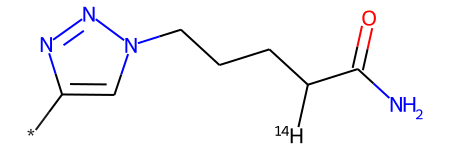

In [30]:
to_mol('*c1cn(CCCC([14H])C(N)=O)nn1')

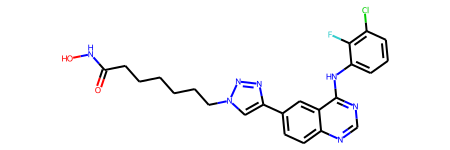

In [34]:
to_mol(reference)

In [31]:
r_df = pd.read_csv('../../smiles_datasets/single_frags.csv')

In [33]:
r_df.head()

,smiles,attachments,weight,atoms
0,*CCOc1c(O)cc(CNC)cc1F,1,198.093032,14
1,*C(C)Oc1c(O)cc(CNC)cc1F,1,198.093032,14
2,*N(C)Cc1cc(O)c(OCC)c(F)c1,1,198.093032,14
3,*Oc1cc(CNC)cc(F)c1OCC,1,198.093032,14
4,*Oc1cc(O)ncc1C(=O)NCCO,1,197.056232,14


In [35]:
r_df.shape

(5262287, 4)

In [36]:
test_14 = r_df.smiles.map(lambda x: '14' in x)

In [37]:
test_14.sum()

155

In [38]:
r_df[test_14]

,smiles,attachments,weight,atoms
1667295,*NCC1C2C3CC4C5C3CC2C5C14,1,174.128275,13
2023994,*CNCC1C2C3CC4C5C3CC2C5C14,1,188.143925,14
2049281,*CC1C2C3CC4C5C3CC2C5C14,1,159.117375,12
4982093,*CCS[14CH3],1,77.030088,4
4983227,*C1=C(O)[14C](=O)OC1C(O)CO,1,161.032590,11
...,...,...,...,...
5247185,*C(C(=O)O)[14CH](O)c1ccccc1,1,167.058411,12
5253011,*[14CH2]C,1,31.042367,2
5253756,*c1cccc2c1B(O)OC2[14CH2]N,1,164.075876,12
5254143,*OP(=O)(O[14CH3])O[14CH3],1,129.006854,7


In [52]:
def remove_isotope(smile):
    mol = to_mol(smile)
    if mol is not None:
        for atom in mol.GetAtoms():
            atom.SetIsotope(0)
            
        smile = to_smile(mol)
        
    return smile

In [53]:
remove_isotope('*c1cccc2c1B(O)OC2[14CH2]N')

'*c1cccc2c1B(O)OC2CN'

In [54]:
r_noiso = maybe_parallel(remove_isotope, r_df.smiles.values, cpus=64)

In [55]:
r_df['smiles2'] = r_noiso

In [56]:
changed = r_df.apply(lambda row: row['smiles']==row['smiles2'], axis=1)

In [57]:
changed.mean(), changed.sum()

(0.9996433109786677, 5260410)

In [58]:
r_df.columns

Index(['smiles', 'attachments', 'weight', 'atoms', 'smiles2'], dtype='object')

In [59]:
r_df = r_df[['smiles2', 'attachments', 'weight', 'atoms']]
r_df.columns = ['smiles', 'attachments', 'weight', 'atoms']

In [60]:
r_df.head()

,smiles,attachments,weight,atoms
0,*CCOc1c(O)cc(CNC)cc1F,1,198.093032,14
1,*C(C)Oc1c(O)cc(CNC)cc1F,1,198.093032,14
2,*N(C)Cc1cc(O)c(OCC)c(F)c1,1,198.093032,14
3,*Oc1cc(CNC)cc(F)c1OCC,1,198.093032,14
4,*Oc1cc(O)ncc1C(=O)NCCO,1,197.056232,14


In [61]:
r_df.to_csv('../../smiles_datasets/single_frags.csv', index=False)

In [49]:
m = to_mol('*[14CH2]C')
for atom in m.GetAtoms():
    atom.SetIsotope(0)

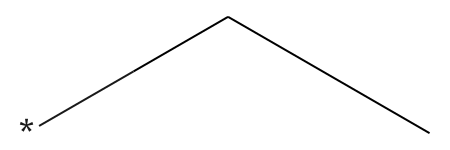

In [50]:
m

In [51]:
to_smile(m)

'*CC'

In [43]:
class Box():
    def __init__(self, ball1, ball2, name):
        self.ball1 = ball1
        self.ball2 = ball2
        self.name = name
        self.first_draw = None
        self.second_draw = None
        
    def sample(self):
        balls = [self.ball1, self.ball2]
        random.shuffle(balls) # inplace shuffle
        self.first_draw = balls[0]
        self.second_draw = balls[1]
        
    def readout(self):
        if self.first_draw is None:
            self.sample()
        
        return [self.name, self.first_draw, self.second_draw]
    
class BoxEnvironment():
    def __init__(self, boxes):
        
        self.boxes = boxes
        self.draws = []
        
    def sample(self):
        box = np.random.choice(self.boxes)
        box.sample()
        self.draws.append(box.readout())
        
    def n_sample(self, n):
        for i in range(n):
            self.sample()
        

In [65]:
box1 = Box('silver', 'silver', 'box1')
box2 = Box('silver', 'gold', 'box2')
box3 = Box('gold', 'gold', 'box3')
box_env = BoxEnvironment([box1, box2, box3])

In [66]:
box_env.n_sample(100000)

In [70]:
gold_second = []
silver_second = []
for draw in box_env.draws:
    if draw[1]=='gold': # first draw gold, defined in problem statement
        if draw[2]=='gold':
            gold_second.append(draw)
        else:
            silver_second.append(draw)

In [71]:
len(gold_second)/(len(gold_second)+len(silver_second))

0.6648629220662526

In [72]:
len(silver_second)/(len(gold_second)+len(silver_second))

0.3351370779337473

In [68]:
all_draws = box_env.draws
gold_first = [i for i in all_draws if i[1]=='gold']

In [69]:
gold_second = [i for i in gold_draws if i[2]=='gold']
gold_second = [i for i in gold_draws if i[2]=='gold']

50081

In [52]:
len(box_env.draws)

1000000

In [54]:
draw_df = pd.DataFrame(box_env.draws, columns=['box', 'first_draw', 'second_draw'])

In [62]:
val_counts = draw_df[draw_df.first_draw=='gold'].second_draw.value_counts().values

In [64]:
val_counts/val_counts.sum()

array([0.66656265, 0.33343735])

In [31]:
l = [2,3]
random.shuffle(l)

In [32]:
l

[3, 2]